In [1]:
from sklearn.datasets import make_regression, load_boston
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
from cvxopt import matrix
from cvxopt import solvers
from numpy import linalg as LA
from sklearn.preprocessing import StandardScaler

In [2]:
def cubic_polynomial(x, y, noise=0.1):
    z = (x-y)**3
    z += np.random.uniform(low=-noise*z, high=noise*z)
    return z

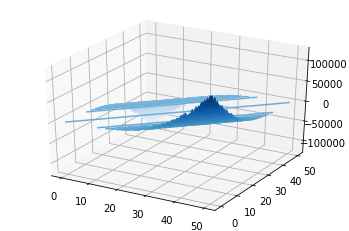

In [3]:
xline = np.linspace(0, 50, 100)
yline = np.linspace(0, 50, 100)
X, Y = np.meshgrid(xline, yline)
zline = cubic_polynomial(X, Y)
ax1 = plt.axes(projection='3d')
ax1.contour3D(X, Y, zline, 200, cmap='Blues')

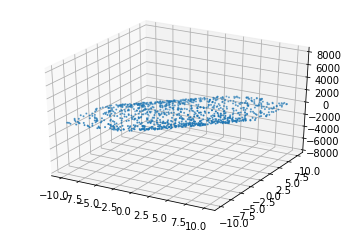

In [4]:
x = np.random.uniform(low=-10, high=10, size=1000)
y = np.random.uniform(low=-10, high=10, size=1000)
z = cubic_polynomial(x, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, marker='o', s=1)

In [5]:
X = np.vstack((x, y)).T
y = z
seed = 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [6]:
def gaussian_kernel(x1, x2, gamma):
    return np.exp(-gamma * LA.norm(x1-x2, axis=-1)**2)

def poly_kernel(x1, x2, degree=3, r=1, gamma=1):
    return (np.dot(x1, x2.T) * gamma + r) ** degree

def laplacian_kernel(x1, x2, gamma):
    return np.exp(-gamma * LA.norm(x1-x2, axis=-1, ord=1))

In [18]:
class svr:
    def __init__(self, gamma=1, degree=3, r=2, kernel="rbf"):
        self.gamma = gamma
        self.degree = degree
        self.r = r
        self.kernel = kernel
        
    def _kernel_function(self, x1, x2):
        if self.kernel == "rbf":
            return gaussian_kernel(x1, x2, self.gamma)
        elif self.kernel == "poly":
            return poly_kernel(x1, x2, self.degree, self.r, self.gamma)
        elif self.kernel == "laplacian":
            return laplacian_kernel(x1, x2, self.gamma)
        else:
            print("unknown kernel")
        
    def _get_gram_matrix(self, X_train):
        m,n = X_train.shape
        K = np.zeros((m, m))
        gamma = 1 / ((X_train.shape[-1]) * X_train.var())
        for i, x_i in enumerate(X_train):
            for j, x_j in enumerate(X_train):
                K[i, j] = self._kernel_function(x_i, x_j)
        return K
            
    def fit(self, X_train, y_train, C=100, epsilon=0.1):
        print("computing gram matrix")
        m,n = X_train.shape
        K = self._get_gram_matrix(X_train)
        P = matrix(np.hstack((np.vstack((K, -K)), np.vstack((-K, K)))))
        q = matrix(np.vstack(((epsilon+y_train).reshape(y_train.shape[0], 1), (epsilon-y_train).reshape(y_train.shape[0], 1))))
        G = matrix(np.vstack((np.eye(2*m)*-1,np.eye(2*m))))
        h = matrix(np.hstack((np.zeros(2*m), np.ones(2*m) * C)))
        A = matrix(np.hstack((np.ones((1, m)), -np.ones((1, m)))))
        b = matrix(0.)
        
        print("running QP solver")
        #Run solver
        sol = solvers.qp(P, q, G, h, A, b)
        alphas = np.array(sol['x'])
        alphas = alphas.reshape(alphas.shape[0])
        
        alphas_plus = alphas[0:m]
        alphas_minus = alphas[m:len(alphas)]
        alpha = alphas_minus - alphas_plus

        print("extracting support vectors")
        sup_vec_idx = np.union1d(np.argwhere(np.logical_or(alphas_minus > 1e-2, alphas_minus < -1e-2)), np.argwhere(np.logical_or(alphas_plus > 1e-2, alphas_plus < -1e-2)))
        X_sup_vec = X_train[sup_vec_idx]
        y_sup_vec = y_train[sup_vec_idx]
        alpha_sup_vec = alpha[sup_vec_idx]
        
        y_sup_vec = y_sup_vec.reshape(y_sup_vec.shape[0])
        print("calculating bias term")
        sup_vec_num = sup_vec_idx.shape[0]
        pred_mtx = np.zeros(sup_vec_num)
        for i in range(sup_vec_num):
            for j in range(sup_vec_num):
                pred_mtx[j] = self._kernel_function(X_sup_vec[j], X_sup_vec[i])
            b += y_sup_vec[i] - epsilon - np.sum(alpha_sup_vec * pred_mtx)
        b /= sup_vec_num
        
        self.X_sup_vec = X_sup_vec
        self.y_sup_vec = y_sup_vec
        self.sup_vec_idx = sup_vec_idx
        self.alpha_sup_vec = alpha_sup_vec
        self.alphas_plus = alphas_plus
        self.alphas_minus = alphas_minus
        self.alpha = alpha
        self.b = b
        
    def predict(self, X_test):
        pred = []
        for x_test in X_test:
            y_hat = 0
            for (x_train, a) in zip(self.X_sup_vec, self.alpha_sup_vec):
                y_hat += a * self._kernel_function(x_test, x_train)
            y_hat += self.b
            pred.append(y_hat)
        return np.array(pred)
    
    def compare_prediction(self, pred, y_test, X_test):
        fig = plt.figure(figsize=plt.figaspect(0.5))
        
        ax = fig.add_subplot(121, projection='3d')
        ax.scatter(X_test[:, 0], X_test[:, 1], y_test, marker='o', s=1, c="green")
        ax.set_zlim([np.min(y_test)-10, np.max(y_test)+10])
        plt.title("true value")
        ax = fig.add_subplot(122, projection='3d')
        ax.scatter(X_test[:, 0], X_test[:, 1], pred, marker='o', s=1, c="blue")
        ax.set_zlim([np.min(y_test)-10, np.max(y_test)+10])
        plt.title("predicted value")
        plt.tight_layout()
        plt.show()

computing gram matrix
running QP solver
     pcost       dcost       gap    pres   dres
 0: -6.4153e+07 -1.6415e+08  2e+09  1e+01  6e-15
 1: -3.8372e+07 -1.4698e+08  5e+08  2e+00  1e-14
 2: -2.2676e+07 -1.0268e+08  1e+08  1e-01  8e-15
 3: -2.2517e+07 -3.2023e+07  1e+07  1e-02  8e-15
 4: -2.3776e+07 -2.6500e+07  3e+06  3e-03  7e-15
 5: -2.4202e+07 -2.5576e+07  1e+06  1e-03  7e-15
 6: -2.4388e+07 -2.5231e+07  9e+05  8e-04  7e-15
 7: -2.4583e+07 -2.4881e+07  3e+05  2e-04  8e-15
 8: -2.4669e+07 -2.4750e+07  8e+04  3e-05  8e-15
 9: -2.4688e+07 -2.4723e+07  4e+04  7e-06  7e-15
10: -2.4699e+07 -2.4710e+07  1e+04  2e-06  7e-15
11: -2.4702e+07 -2.4706e+07  3e+03  4e-07  7e-15
12: -2.4704e+07 -2.4704e+07  4e+02  5e-08  8e-15
13: -2.4704e+07 -2.4704e+07  4e+01  4e-09  8e-15
14: -2.4704e+07 -2.4704e+07  7e-01  6e-11  8e-15
Optimal solution found.
extracting support vectors
calculating bias term


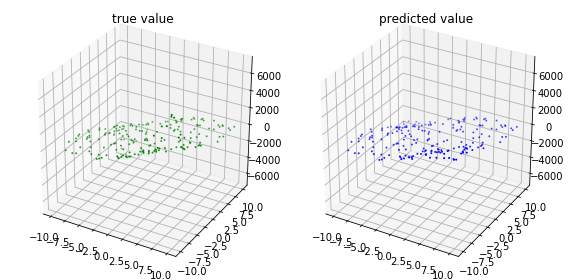

In [19]:
gamma = 1 / ((X_train.shape[-1]) * X_train.var())
reg = svr(gamma=gamma)
reg.fit(X_train, y_train)
pred = reg.predict(X_test)
reg.compare_prediction(pred, y_test, X_test)